In [1]:
# 집값예측 & 캐글 대회 체험
 # 특성들의 상관관계를 히트맵으로 확인하고 특성을 제거하는 실험을 다수 진행 하였으나 효과 없음
 # 11번 노드의 가이드대로 하이퍼파라미터 튜닝으로 RMSLE 값을 낮추는 실험을 진행
 # 캐글 submission Private Score 116919


In [553]:
#시각화를 위한 matplotlib 환경설
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print('check')

check


In [554]:
#필요 라이브러리 

import warnings #경고 메시지 제어
warnings.filterwarnings("ignore") # 경고 메시지 무시

import os
from os.path import join #join 함수 임포트 파일 경로 결합

import pandas as pd #데이터프레임 조작
import numpy as np #수치

import missingno as msno #결측치 시각화

from sklearn.ensemble import GradientBoostingRegressor #그래디언트 부스팅 알고리즘
from sklearn.model_selection import KFold, cross_val_score # k 폴드 교차 검증
import xgboost as xgb #그래디언트 부스팅 트리 알고리즘 구현체
import lightgbm as lgb #그래디언트 부스팅 프레임워크

import seaborn as sns #데이터 시각화

print('check')

check


In [555]:
# 데이터 경로 지정

data_dir = os.path.join(os.getenv('HOME'), 'work/kaggle_kakr_housing/data')
# hint : os.getenv를 사용하거나 직접 경로를 작성

train_data_path = os.path.join(data_dir, 'train.csv')
sub_data_path = os.path.join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/home/jovyan/work/kaggle_kakr_housing/data/train.csv
/home/jovyan/work/kaggle_kakr_housing/data/test.csv


In [556]:
# 데이터 확인
# '''
# 1. ID : 집을 구분하는 번호
# 2. date : 집을 구매한 날짜
# 3. price : 타겟 변수인 집의 가격
# 4. bedrooms : 침실의 수
# 5. bathrooms : 침실당 화장실 개수
# 6. sqft_living : 주거 공간의 평방 피트
# 7. sqft_lot : 부지의 평방 피트
# 8. floors : 집의 층수
# 9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
# 10. view : 집이 얼마나 좋아 보이는지의 정도
# 11. condition : 집의 전반적인 상태
# 12. grade : King County grading 시스템 기준으로 매긴 집의 등급
# 13. sqft_above : 지하실을 제외한 평방 피트
# 14. sqft_basement : 지하실의 평방 피트
# 15. yr_built : 집을 지은 년도
# 16. yr_renovated : 집을 재건축한 년도
# 17. zipcode : 우편번호
# 18. lat : 위도
# 19. long : 경도
# 20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
# 21. sqft_lot15 : 근처 15가구의 부지, 평방 피트
# '''

In [557]:
# 데이터 로딩 및 차원 확인
train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)
print(f'train data dim : {train.shape}')
print(f'test data dim : {test.shape}')
train.head()

train data dim : (15035, 21)
test data dim : (6468, 20)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [558]:
# date 전처리
 # .astype(int)를 사용하여 문자열 series를 정수형 데이터로 처리

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [559]:
numeric_train_data = train.select_dtypes(include=[np.number])

In [560]:
correlation_matrix = numeric_train_data.corr()

In [561]:
print("\n'price'와의 상관관계:")
print(correlation_matrix['price'].sort_values(ascending=False))


'price'와의 상관관계:
price            1.000000
sqft_living      0.702899
grade            0.667211
sqft_above       0.608577
sqft_living15    0.586419
bathrooms        0.525479
view             0.400806
bedrooms         0.323672
sqft_basement    0.322218
lat              0.301604
waterfront       0.265738
floors           0.262588
yr_renovated     0.140808
sqft_lot         0.096793
sqft_lot15       0.086384
yr_built         0.047290
condition        0.039740
long             0.023547
id               0.020899
date             0.007717
zipcode         -0.051498
Name: price, dtype: float64


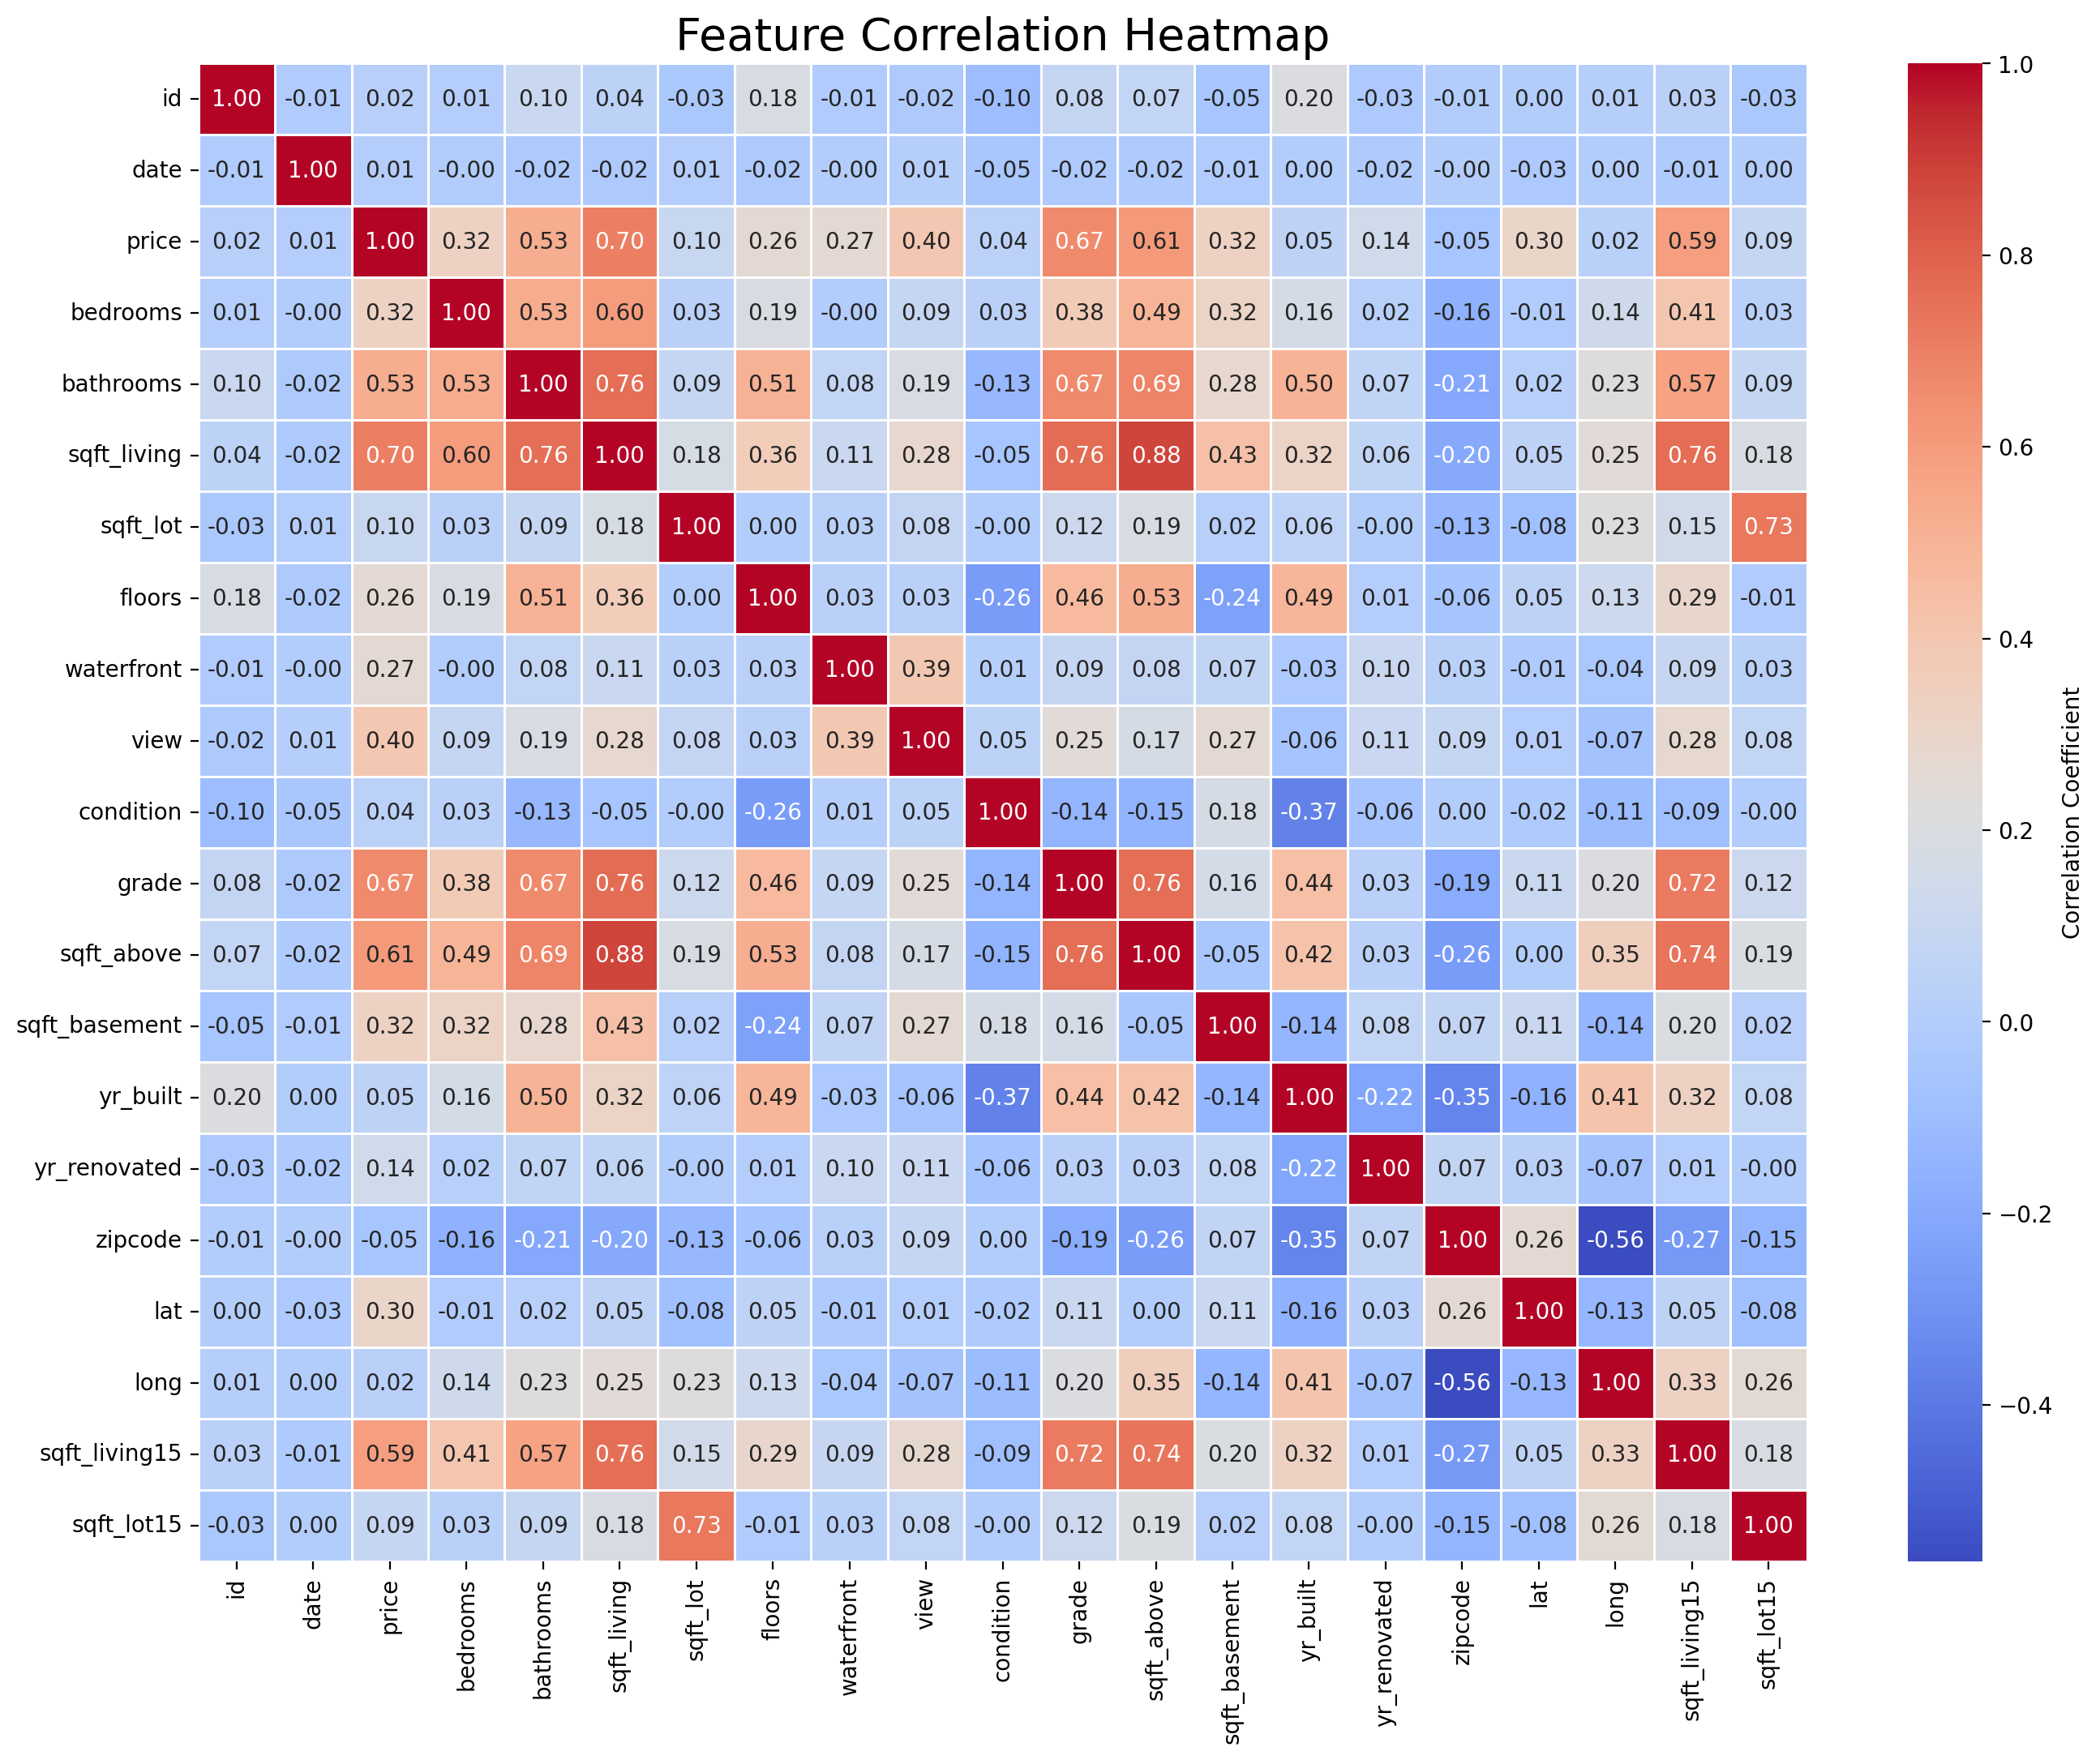

In [562]:
plt.figure(figsize=(16, 12)) # 그래프 크기 설정
sns.heatmap(correlation_matrix,
            annot=True,     # 각 셀에 상관계수 값 표시
            cmap='coolwarm', # 색상 팔레트 설정 (양의 상관관계는 따뜻한 색, 음의 상관관계는 차가운 색)
            fmt=".2f",      # 소수점 둘째 자리까지 표시
            linewidths=.5,  # 셀 사이의 선 추가
            cbar_kws={'label': 'Correlation Coefficient'}) # 컬러바 라벨 추가

plt.title('Feature Correlation Heatmap', fontsize=20) # 그래프 제목
plt.show()

In [563]:
# 학습데이터에서 라벨 제거하기
 # price 칼럼은 맞춰야할 정답임으로 y변수로 저장하고 제거
 # 데이터 분석 과정에서 칼럼을 없애고 싶다면 pandas.DataFrame.drop도 사용할 수 있다

y = train['price']
del train['price']

print(train.columns)
print(y.head())

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
0    221900.0
1    180000.0
2    510000.0
3    257500.0
4    291850.0
Name: price, dtype: float64


In [564]:
# id 칼럼 삭제

del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [565]:
# 칼럼 추가 삭제
 # 상관 관계가 낮은 컬럼을 제거하면서 예측율 추이를 살폈으나 효과 없음
#train = train.drop(['date', 'sqft_lot', 'floors', 'waterfront', 'sqft_above', 'sqft_basement','sqft_living15', 'sqft_lot15', 'zipcode', 'long'], axis=1)

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [566]:
# test date 데이터 전처리
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

# test = test.drop(['date', 'sqft_lot', 'floors','waterfront', 'sqft_above','sqft_basement','sqft_living15', 'sqft_lot15', 'zipcode', 'long'], axis=1)
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [567]:
# 타겟 데이터 y 확인

y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

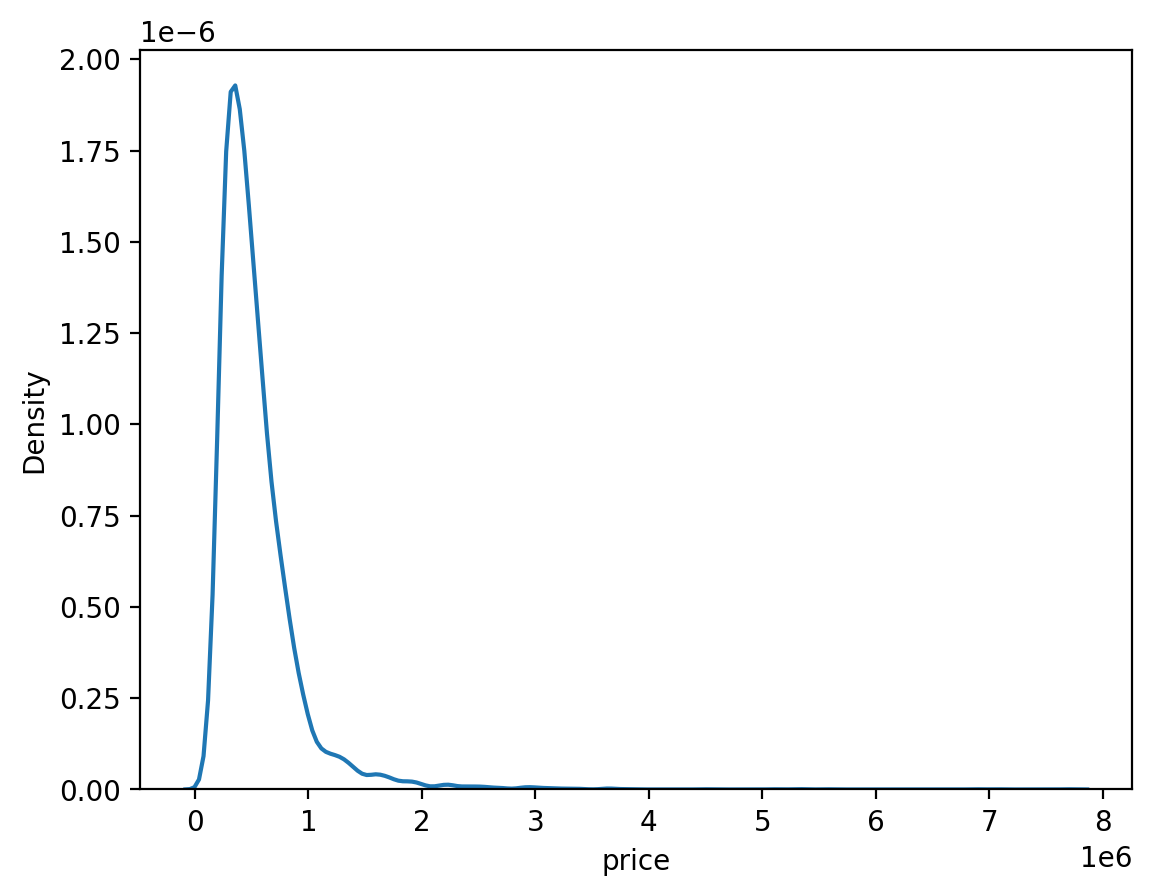

In [568]:
# y (가격)분포 확인_시각

sns.kdeplot(y)
plt.show()

In [569]:
# y 정규분포로 변환
 # np.log1p()함수로 변환, 이후 예측 한 뒤 다시 np.exam1()으로 되돌림

y=np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

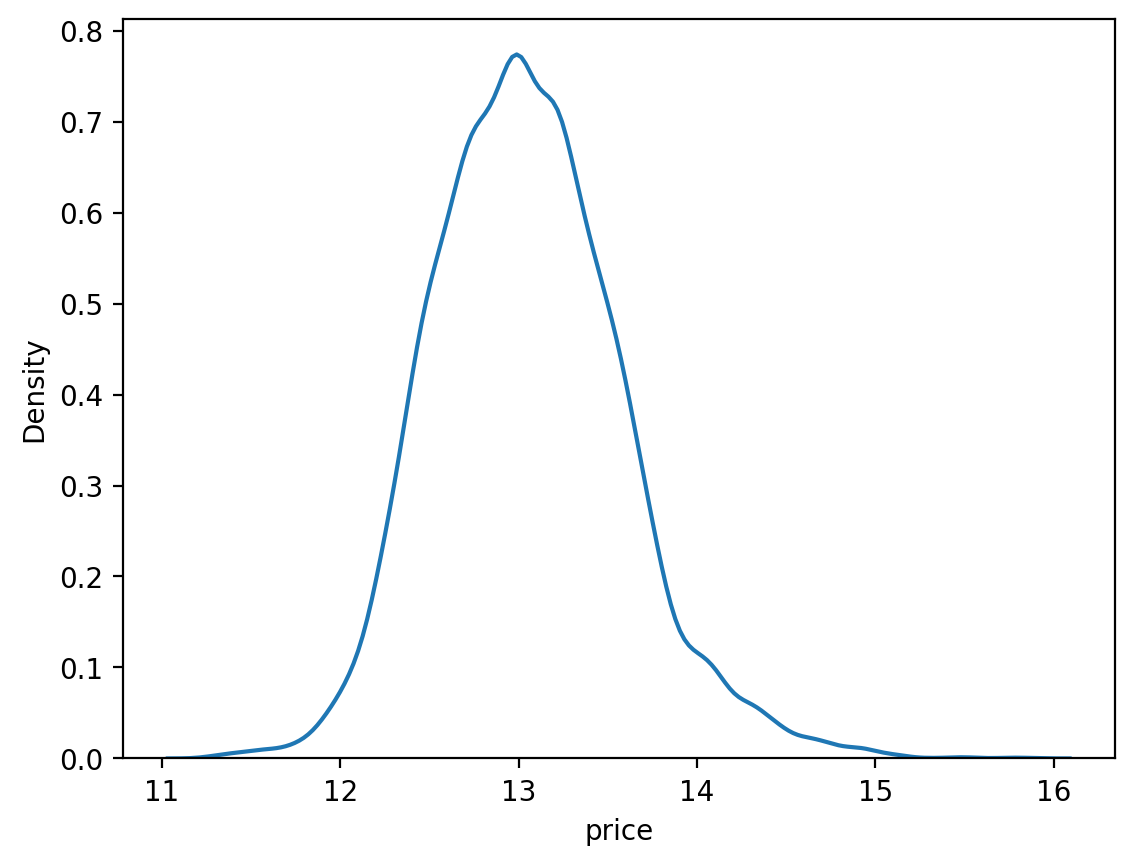

In [570]:
# 그래프로 확인
sns.kdeplot(y)
plt.show()


In [571]:
#전체 데이터의 자료형을 확인

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [572]:
# 데이터셋을 훈련셋과 검증셋으로 나누기위한 train_test_split 과 RMSE 점수를 계산하기 위한 mean_squared_error 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('check')


check


In [573]:
# RMSE 점수 계산을 위한 함수 제작

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('check')

check


In [574]:
# 학습 모델 임포트

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('check')

check


In [575]:
# 모델 리스트 생성 및 랜덤 시드값 결정

random_state=2020 #None을 넣으면 모델이 시드값 선택

gboost=GradientBoostingRegressor(random_state=random_state)
xboost=XGBRegressor(random_state=random_state)
lightgbm=LGBMRegressor(random_state=random_state)
rdforest=RandomForestRegressor(random_state=random_state)

models=[gboost, xboost, lightgbm, rdforest]

print('check')

check


In [576]:
# 모델 교차 검증 및 성능 평가 함수

def get_scores(models, train, y):
    df={}

    for model in models:
        model_name=model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred=model.predict(X_test)

        df[model_name]=rmse(y_test, y_pred)

        score_df=pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE',ascending=False)
        
    return score_df

get_scores(models, train, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.047779


,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125486.944616
XGBRegressor,117618.223554
LGBMRegressor,111920.367359


In [577]:
#GridSearchCV 임포트

from sklearn.model_selection import GridSearchCV



In [578]:

# GridSearchCV에 입력되는 인자들은 다음과 같습니다.

# param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
# scoring : 모델의 성능을 평가할 지표
# cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
# verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
# n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수


In [579]:
# 파라미터를 넣고 진행과정을 체크 하는 코드는 아래 함수로 만들어두어 주석처리함
'''
param_grid = {
    'n_estimators': [50, 342],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)
'''

"\nparam_grid = {\n    'n_estimators': [50, 342],\n    'max_depth': [1, 10],\n}\n\nmodel = LGBMRegressor(random_state=random_state)\n\ngrid_model = GridSearchCV(model, param_grid=param_grid,                         scoring='neg_mean_squared_error',                         cv=5, verbose=1, n_jobs=5)\n\ngrid_model.fit(train, y)\n"

In [580]:
'''
grid_model.cv_results_
'''

'\ngrid_model.cv_results_\n'

In [581]:
'''
params = grid_model.cv_results_['params']
params
'''

"\nparams = grid_model.cv_results_['params']\nparams\n"

In [582]:
'''
score = grid_model.cv_results_['mean_test_score']
score
'''

"\nscore = grid_model.cv_results_['mean_test_score']\nscore\n"

In [583]:
#params와 score을 데이터 프레임으로 출력
'''
results=pd.DataFrame(params)
results['score']=score
results['RMSLE'] = np.sqrt(-1 * results['score'])
results=results.sort_values('RMSLE')
results
'''

"\nresults=pd.DataFrame(params)\nresults['score']=score\nresults['RMSLE'] = np.sqrt(-1 * results['score'])\nresults=results.sort_values('RMSLE')\nresults\n"

In [584]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다.
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [585]:
# my_GridSearch() 함수로 그리드 탐색 하기
param_grid = {
    'n_estimators': [300, 342],
    'max_depth': [10],
    #'learning_rate': [0.1, 0.01],
    'num_leaves': [26],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,max_depth,n_estimators,num_leaves,score,RMSLE
1,10,342,26,-0.026024,0.161319
0,10,300,26,-0.026040,0.161370


In [586]:
#가장 좋은 조합의 파라미터로 구성된 모델 준비 및 학습 후 예측 결과 생성
model = LGBMRegressor(max_depth=10, n_estimators=100, num_leaves=26, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)
prediction

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


array([ 517674.85438476,  457636.16607185, 1403669.87412228, ...,
        464475.93182755,  323614.8131905 ,  424223.28042796],
      shape=(6468,))

In [587]:
import os
print(os.getcwd())

/home/jovyan/work/workplace/AIFFEL_quest_rs/Exploration/Quest02


In [588]:
#샘플 파일 가져오
data_dir = os.path.join(os.getenv('HOME'), 'work/kaggle_kakr_housing/data')

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [589]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.176749e+05
1,15036,4.576362e+05
2,15037,1.403670e+06
3,15038,3.171149e+05
4,15039,3.280018e+05


In [590]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.161319')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/jovyan/work/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161319.csv
